In [231]:
import numpy as np
from operator import add
from scipy import interp
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
%matplotlib inline
import time
import sqlite3
import pandas as pd
from scipy.interpolate import interp1d
import random 
import itertools
from datetime import datetime
from scipy import interp
from scipy.interpolate import RegularGridInterpolator
plt.style.use('ggplot')

## Datas 

In [8]:
PATH_DATA = '/Users/mathildebadoual/code/ev_controller/data/'
PATH_REPORT = '/Users/mathildebadoual/code/ev_controller/report/'

In [214]:
data_prices = pd.read_csv(PATH_DATA + 'price_demand.csv')

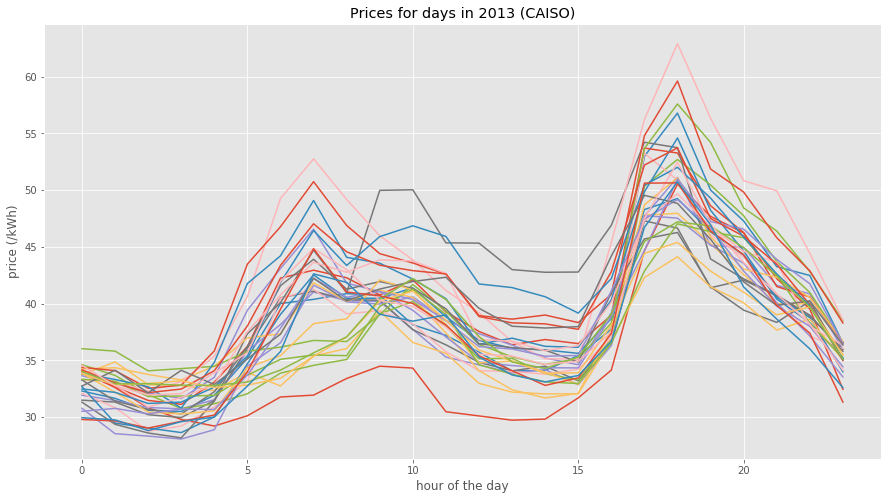

In [215]:
plt.figure(figsize=(15, 8))
for day in range(1, 31):
    for month in range(1, 2):
        plt.plot(range(0, 24), data_prices[(data_prices['day'] == day) & (data_prices['Month'] == month) & (data_prices['Year'] == 2013)]['Price'])
plt.xlabel('hour of the day')
plt.ylabel('price (/kWh)')
plt.title('Prices for days in 2013 (CAISO)')
plt.savefig(PATH_REPORT + 'prices_day.png')

## Markov Chain: EV data

In [138]:
data_ev = pd.read_csv(PATH_DATA + 'EV_data.csv')
ID_26 = data_ev['ID:26']     #Car_ID:26
ID_370 = data_ev['ID:370']   #Car_ID:370
ID_545 = data_ev['ID:545']   #Car_ID:545
ID_661 = data_ev['ID:661']   #Car_ID:661
ID_4767 = data_ev['ID:4767'] #Car_ID:4767

#Creating and resizing EV_array into (ID , Week, DOW, HOD)
ev_array = np.array([ID_26, ID_370, ID_545, ID_661, ID_4767])
ev_array.resize(5,47,7,24)

In [139]:
array = np.zeros((len(data.columns[1:])*len(data_ev), 5))
j = 0
for car_index, car in enumerate(data_ev.columns[1:]):
    for i in range(len(data_ev)):
        value = datetime.strptime(data_ev['localminute'].iloc[i], '%m/%d/%Y %H:%M')
        week_of_year = int(value.strftime('%W'))
        day_of_week = int(value.strftime('%w'))
        hour_of_day = int(value.strftime('%H'))
        array[j, :] = [car_index, week_of_year, day_of_week, hour_of_day, data_ev[car].iloc[i]]
        j += 1
        
data_ev_resized = pd.DataFrame(array, columns=['car_index', 'week_of_year', 'day_of_week', 'hour_of_day', 'energy_consumption'])

In [140]:
presence_list = []
for element in data_ev_resized['energy_consumption']:
    if element <= 0.01:
        presence_list.append(0)
    else:
        presence_list.append(1)
        
data_ev_resized['presence'] = presence_list

In [15]:
#Creating Markov chain!
#Considering (5 x 47 x 7 ) different data arrays, we find the probablility
#matrix pij(k), i for charging, j for not charging.
#At each time step we count the 
p_list =[ ]  #initializing list containing the probability matrices
for k in range(23):  # 23 cuz probability doesn't count for last timestep
    Num_charging = [0, 0, 0]     #[num_charging now, num_STILL charging at k+1, num_n0t charging at k+1]
    Num_not_charging = [0, 0, 0] #[num_not charging now, num_charging next k, num STILL not charging next k]
    for j in range(47):
        for v in range(7):
            if any(i >= 0.3 for i in ev_array[:,j,v,k]): #I use 0.3 as charging benchmark
                Num_charging[0] += 1
                if any(i >= 0.3 for i in ev_array[:,j,v,k+1]):
                    Num_charging[1] += 1
                else:
                    Num_charging[2] += 1
            else:
                Num_not_charging[0] += 1
                if any(i >= 0.3 for i in ev_array[:,j,v,k+1]):
                    Num_not_charging[1] += 1
                else:
                    Num_not_charging[2] += 1
    p_ij = np.zeros((2,2))
    p_ij[0,0] = Num_charging[1]/Num_charging[0]  #probability of moving from i to i
    p_ij[0,1] = Num_charging[2]/Num_charging[0]  #probability of moving from i to j
    p_ij[1,0] = Num_not_charging[1]/Num_not_charging[0] 
    p_ij[1,1] = Num_not_charging[2]/Num_not_charging[0]
    p_list.append(p_ij)
    

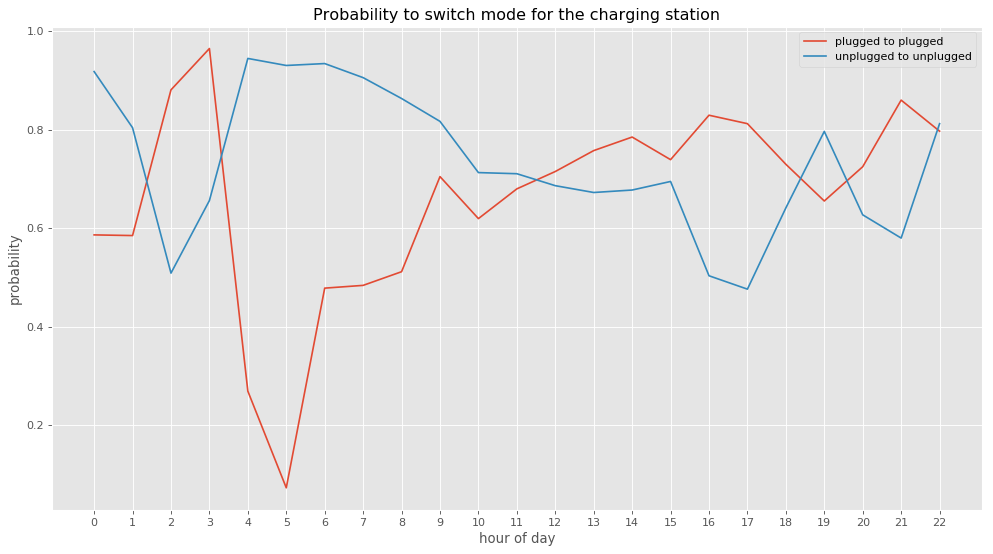

In [16]:
P = np.array(p_list)
fs = 14

plt.figure(dpi = 80, figsize = (15,8), tight_layout = False)
plt.plot(np.linspace(0,22,23), P[:,0,0], label = 'plugged to plugged')
plt.plot(np.linspace(0,22,23), P[:,1,1], label = 'unplugged to unplugged')
plt.xticks(np.linspace(0,22,23))
plt.ylabel('probability', fontsize = fs-2)
plt.xlabel('hour of day', fontsize = fs-2)
plt.title('Probability to switch mode for the charging station')
plt.legend()
plt.show()
plt.savefig(PATH_REPORT + 'probability_switch_station.png')

In [410]:
horizon = 48
num_interp = 20

data = pd.read_csv('/Users/mathildebadoual/code/ev_controller/data/price_demand.csv')

data_price = data['Price'].values

data_price_grid = np.linspace(0, max(data_price), num_interp)
# Interpolation function: interp(arg1, arg2, ...)
T = range(len(data_price))
t = np.mod(np.divide(T, 2), horizon / 2);

counts = np.zeros((num_interp, num_interp, horizon))
P_prices = np.zeros((num_interp, num_interp, horizon))

for idx in range(len(data_price)-1):
    i = int(interp(data_price[idx], data_price_grid, range(num_interp)))
    j = int(interp(data_price[idx+1], data_price_grid, range(num_interp)))
    k = int(t[idx] * 2 + 1)-1
    counts[i, j, k] += 1

for i in range(num_interp):
    for k in range(horizon):
        # Compute fraction of times irradiance level goes from ii to jj in time step kk
        # out of ALL transitions out of level ii
        if sum(counts[i, :, k]) != 0:
            P_prices[i, :, k] = counts[i, :, k] / sum(counts[i, :, k])

In [411]:
np.sum(P_prices[:, :, 1], axis=0)

array([0.        , 0.67204301, 1.4258546 , 1.25253771, 0.64956468,
       1.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [412]:
presence_to_test = [data_ev_resized['presence'][i:i+24] for i in range(0, len(data_ev_resized['presence']), 24)]
prices_to_test = [data_price[i:i+24] for i in range(0, len(data_price), 24)]

In [413]:
prices_day = data_prices[(data_prices['day'] == 1) & (data_prices['Month'] == 1) & (data_prices['Year'] == 2013)]['Price']
prices_interp = interp1d(np.linspace(0, 23, 24), prices_day)
prices = prices_interp(np.linspace(0, 23, N))
#prices = np.flip(prices_interp(np.linspace(0, 23, N)), axis=0)

## Regular DeterministicControl

In [367]:
## SET PARAMETERS
num_station = 2
ns = 10

N = 24
c = 10
alpha = 0.003
delta_t = 1
u_max = 0.3
U_max = 0.5

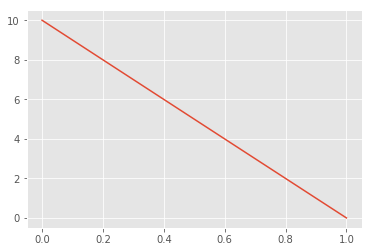

In [368]:
def satisfaction_function(x):
    return c * (1 - np.exp(alpha * (1 - x)))/(1 - np.exp(alpha))

x = np.linspace(0, 1, 100)
plt.plot(x, satisfaction_function(x))

In [362]:
def deterministic_control(num_station, ns, c, alpha, u_max, U_max, N):
    
    SOC_shape = tuple([ns for i in range(num_station)])   # This creates a tuple is needed to for any np.reshape operation later
    SOC_grid = np.array(list(itertools.product(np.linspace(0, 1, ns), repeat = num_station))) # repeat added...
    SOC_tuple = tuple([np.linspace(0,1,ns) for i in range(num_station)])  # This is needed for the interpolation later
    
    u_star = np.zeros((num_station, len(SOC_grid), N))
    V = 100000 * np.ones((len(SOC_grid), N+1))
    
    ## SOLVE DYNAMIC PROGRAM
    start = time.time()

    # Boundary Condition of Value Function (Principle of Optimality)

    V[-1,N] = 0     #This ensures that the progam only accepts SOC of 1 for all stations at time N.

    # Iterate backward in time
    for k in range(N-1, 0, -1):

        # Iterate over SOC
        for idx in range(0, len(SOC_grid)):
    
            # Find dominant bounds for u_batt
            lb = 0
            ub = [min(u_max, (1.0 - SOC_grid[idx, i])/delta_t) for i in range(num_station)]
            
            # Grid Battery Power between dominant bounds
            u_batt_init = np.array(list(itertools.product(np.linspace(lb, ub[0], ns), np.linspace(lb, ub[1], ns)))) #initializing u_batt
            #for i in range(num_station):
            #    u_batt_init[:,i] = u_batt_init[:,i] * (ub[i] / u_max)  #This ensures that the upperbounds are respected if ub < u_max
            
            u_batt_delete = []            # This list is used to delete u_batt values that break the u_max constraint
            for i in range(len(u_batt_init)):
                if u_batt_init[i].sum() > U_max:
                    u_batt_delete.append(i)
            
            u_batt_grid = np.delete(u_batt_init, u_batt_delete, 0)  #This is the real u_batt_grid used in the rest of the code
            #TODO: enlever ceux qui ne respectent pas sum(u_i) <= Umax
            
            # compute next SOC using dynamics
            SOC_nxt = SOC_grid[idx] + delta_t * u_batt_grid
        
            # Cost (no satisfaction)
            satisfaction_k = np.array([np.sum(c * (1 - np.exp(alpha * (1 - SOC_nxt[i, :])))/(1 - np.exp(alpha))) for i in range(u_batt_grid.shape[0])])
            g_k = prices[k] * u_batt_grid.sum(axis = 1) + satisfaction_k
            
            # Compute value function at nxt time step (need to interpolate)
            V_nxt = 100000*np.ones((len(SOC_nxt),1))
            V_temp = V[:,k+1].reshape(SOC_shape)      #V[k+1] has to be reshaped to work in interpolation
            V_interp_function = RegularGridInterpolator(SOC_tuple, V_temp, method = 'linear')  #n-dimensional interpolation function
        
            V_nxt = V_interp_function(SOC_nxt)

        
            # Value Function (Principle of Optimality)
            V[idx, k] = (delta_t * g_k + V_nxt.T).min()
            ind = np.argmin(delta_t * g_k + V_nxt.T)
            
            # Save Optimal Control
            u_star[:, idx, k] = u_batt_grid[ind]
        
    # DP Timer
    end = time.time()
    print(str(end - start) + " seconds")
    return u_star, SOC_shape, SOC_tuple, SOC_grid

In [363]:
def simulation(u_star, presence, prices, SOC_shape, SOC_tuple, SOC_grid, num_station, N):

    ## Simulate Results

    random.seed(10)

    # Preallocate
    SOC_sim = np.zeros((num_station, N))
    u_batt_sim = np.zeros((num_station, N))
    J_sim_cost = np.zeros((N))
    J_sim_sat = np.zeros((N))

    # Initialize
    SOC_0 = np.array([0.2, 0.3])
    SOC_sim[:, 0] = SOC_0

    # Simulate PHEV Dynamics
    for k in range(0, N-1):
    
    #     # Use optimal battery power, for given SOC
    #     u_batt_sim[:, k] = np.reshape(interp(SOC_sim[:, k].flatten(), SOC_grid.flatten(), u_star[:, :, k].flatten()), (num_station,))
    #     for i in range(num_station):
    #         u_batt_sim[i, k] = presence[i, k] * u_batt_sim[i, k]
    
        # Use optimal battery power, for given SOC
        for i in range(num_station):
            u_temp_sim = u_star[i, :, k].reshape(SOC_shape)
            u_interp_func= RegularGridInterpolator(SOC_tuple, u_temp_sim, method = 'linear') 
            u_batt_sim[i, k] = presence[i, k] * u_interp_func(SOC_sim[:,k])      #interpolation necessary for selectign each element of u_batt_sim!
        
        # Fuel Consumption
        satisfaction_k = np.sum(c * (1 - np.exp(alpha * (1 - SOC_sim[:, k])))/(1 - np.exp(alpha)))
        J_sim_cost[k] = prices[k] * np.sum(u_batt_sim[:, k]) 
        J_sim_sat[k] = satisfaction_k
    
    
        # Time-step SOC dynamics
        SOC_sim[:, k+1] = (SOC_sim[:, k] + delta_t * u_batt_sim[:, k]) 
    
        for i in range(num_station):
            if presence[i, k] == 0 and presence[i, k+1] == 1:
                SOC_sim[i, k+1] = random.uniform(0, 1)
            else:
                SOC_sim[i, k+1] = presence[i, k] * SOC_sim[i, k+1]
    return np.sum(J_sim_cost), np.sum(J_sim_sat)

## Stochastic Control

In [386]:
def stochastic_control(num_station, ns, c, alpha, u_max, U_max, N):
    
    SOC_shape = tuple([ns for i in range(num_station)])   # This creates a tuple is needed to for any np.reshape operation later

    SOC_grid = np.array(list(itertools.product(np.linspace(0, 1, ns), repeat = num_station))) # repeat added...

    SOC_tuple = tuple([np.linspace(0,1,ns) for i in range(num_station)])  # This is needed for the interpolation later
    
    u_star = np.zeros((num_station, len(SOC_grid), N))
    V = 10000000 * np.ones((len(SOC_grid), N+1))
    #V[ :, N] = satisfaction_function(SOC_grid[:,0]) #+ satisfaction_function(SOC_grid[:,1])
    V[-1, N] = 0  

    ## SOLVE DYNAMIC PROGRAM
    start = time.time()

    # Boundary Condition of Value Function (Principle of Optimality)
    # V[:, :, N] = np.zeros((num_station, len(SOC_grid)))

    # Iterate backward in time
    for k in range(N-1, 0, -1):

        # Iterate over SOC
        for idx in range(0, len(SOC_grid)):
    
            # Find dominant bounds for u_batt
            # Find dominant bounds for u_batt
            lb = 0
            ub = [min(u_max, (1.0 - SOC_grid[idx, i])/delta_t) for i in range(num_station)]
                
            # Grid Battery Power between dominant bounds
            u_batt_init = np.array(list(itertools.product(np.linspace(lb, ub[0], ns), np.linspace(lb, ub[1], ns)))) #initializing u_batt
            u_batt_init = u_batt_init * ub/u_max  #This ensures that the upperbounds are respected if ub < u_max
        
            u_batt_del = u_batt_init.sum(axis = 1) > U_max
            u_batt_grid = u_batt_init[(u_batt_del == False)]
            #This is the real u_batt_grid used in the rest of the code
            #TODO: enlever ceux qui ne respectent pas sum(u_i) <= Umax
        
            # compute next SOC using dynamics
            SOC_nxt_00 = 0 * u_batt_grid
            SOC_nxt_11 = SOC_grid[idx] + delta_t * u_batt_grid
            SOC_nxt_01 = random.uniform(0, 1) * np.ones(u_batt_grid.shape)# tbd
            SOC_nxt_10 = 0 * u_batt_grid
        
            # Cost of satisfaction
            satisfaction_k_00 = np.zeros((u_batt_grid.shape[0]))
            satisfaction_k_11 = np.array([np.sum(c * (1 - np.exp(alpha * (1 - SOC_nxt_11[i, :])))/(1 - np.exp(alpha))) for i in range(u_batt_grid.shape[0])])
            satisfaction_k_01 = np.array([np.sum(c * (1 - np.exp(alpha * (1 - SOC_nxt_01[i, :])))/(1 - np.exp(alpha))) for i in range(u_batt_grid.shape[0])])
            satisfaction_k_10 = np.zeros((u_batt_grid.shape[0]))
            g_k_00 = prices[k] * np.array([np.sum(u_batt_grid[i, :]) for i in range(u_batt_grid.shape[0])]) + satisfaction_k_00
            g_k_11 = prices[k] * np.array([np.sum(u_batt_grid[i, :]) for i in range(u_batt_grid.shape[0])]) + satisfaction_k_11
            g_k_01 = prices[k] * np.array([np.sum(u_batt_grid[i, :]) for i in range(u_batt_grid.shape[0])]) + satisfaction_k_01
            g_k_10 = prices[k] * np.array([np.sum(u_batt_grid[i, :]) for i in range(u_batt_grid.shape[0])]) + satisfaction_k_10
            
            if k == 23:
                g_k = g_k_11
            else:
                g_k = P[k, 0, 0] * g_k_00 + P[k, 1, 1] * g_k_11 + P[k, 0, 1] * g_k_01 + P[k, 1, 0] * g_k_10
            
            # Compute value function at nxt time step (need to interpolate)
        
            V_nxt_init = 10000000*np.ones((len(SOC_nxt_11),1)) #initializing V_nxt
            V_temp = V[:,k+1].reshape(SOC_shape)      #V[k+1] has to be reshaped to work in interpolation
            V_interp_function = RegularGridInterpolator(SOC_tuple, V_temp, method = 'linear')  #n-dimensional interpolation function
        
            V_nxt_00 = V_interp_function(SOC_nxt_00)
            V_nxt_11 = V_interp_function(SOC_nxt_11)
            V_nxt_01 = V_interp_function(SOC_nxt_01)
            V_nxt_10 = V_interp_function(SOC_nxt_10)
                
            if k == 23:
                V_nxt = V_nxt_11
            else:
                V_nxt = P[k, 0, 0] * V_nxt_00 + P[k, 1, 1] * V_nxt_11 + P[k, 0, 1] * V_nxt_01 + P[k, 1, 0] * V_nxt_10
        
            # Value Function (Principle of Optimality)
            V[idx, k] = (delta_t * g_k + V_nxt).min()
            ind = np.argmin(delta_t * g_k + V_nxt)
        
            # Save Optimal Control
            u_star[:, idx, k] = u_batt_grid[ind]
        
    # DP Timer
    end = time.time()
    print(str(end - start) + " seconds")
    return u_star, SOC_shape, SOC_tuple, SOC_grid

In [406]:
def stochastic_control_with_price(num_station, ns, c, alpha, u_max, U_max, N):
    
    SOC_shape = tuple([ns for i in range(num_station)])   # This creates a tuple is needed to for any np.reshape operation later

    SOC_grid = np.array(list(itertools.product(np.linspace(0, 1, ns), repeat = num_station))) # repeat added...

    SOC_tuple = tuple([np.linspace(0,1,ns) for i in range(num_station)])  # This is needed for the interpolation later
    
    u_star = np.zeros((num_station, len(SOC_grid), N))
    V = 10000000 * np.ones((len(SOC_grid), N+1))
    #V[ :, N] = satisfaction_function(SOC_grid[:,0]) #+ satisfaction_function(SOC_grid[:,1])
    V[-1, N] = 0  

    ## SOLVE DYNAMIC PROGRAM
    start = time.time()

    # Boundary Condition of Value Function (Principle of Optimality)
    # V[:, :, N] = np.zeros((num_station, len(SOC_grid)))

    # Iterate backward in time
    for k in range(N-1, 0, -1):

        # Iterate over SOC
        for idx in range(0, len(SOC_grid)):
    
            # Find dominant bounds for u_batt
            # Find dominant bounds for u_batt
            lb = 0
            ub = [min(u_max, (1.0 - SOC_grid[idx, i])/delta_t) for i in range(num_station)]
                
            # Grid Battery Power between dominant bounds
            u_batt_init = np.array(list(itertools.product(np.linspace(lb, ub[0], ns), np.linspace(lb, ub[1], ns)))) #initializing u_batt
            u_batt_init = u_batt_init * ub/u_max  #This ensures that the upperbounds are respected if ub < u_max
        
            u_batt_del = u_batt_init.sum(axis = 1) > U_max
            u_batt_grid = u_batt_init[(u_batt_del == False)]
            #This is the real u_batt_grid used in the rest of the code
            #TODO: enlever ceux qui ne respectent pas sum(u_i) <= Umax
        
            # compute next SOC using dynamics
            SOC_nxt_00 = 0 * u_batt_grid
            SOC_nxt_11 = SOC_grid[idx] + delta_t * u_batt_grid
            SOC_nxt_01 = random.uniform(0, 1) * np.ones(u_batt_grid.shape)# tbd
            SOC_nxt_10 = 0 * u_batt_grid
        
            # Cost of satisfaction
            satisfaction_k_00 = np.zeros((u_batt_grid.shape[0]))
            satisfaction_k_11 = np.array([np.sum(c * (1 - np.exp(alpha * (1 - SOC_nxt_11[i, :])))/(1 - np.exp(alpha))) for i in range(u_batt_grid.shape[0])])
            satisfaction_k_01 = np.array([np.sum(c * (1 - np.exp(alpha * (1 - SOC_nxt_01[i, :])))/(1 - np.exp(alpha))) for i in range(u_batt_grid.shape[0])])
            satisfaction_k_10 = np.zeros((u_batt_grid.shape[0]))
            
            g_k_final = np.zeros((u_batt_grid.shape[0]))
            
            for i in range(P_prices.shape[0]):
                price = interp(prices[k], data_price_grid, range(num_interp))
                g_k_00 = price * np.array([np.sum(u_batt_grid[i, :]) for i in range(u_batt_grid.shape[0])]) + satisfaction_k_00
                g_k_11 = price * np.array([np.sum(u_batt_grid[i, :]) for i in range(u_batt_grid.shape[0])]) + satisfaction_k_11
                g_k_01 = price * np.array([np.sum(u_batt_grid[i, :]) for i in range(u_batt_grid.shape[0])]) + satisfaction_k_01
                g_k_10 = price * np.array([np.sum(u_batt_grid[i, :]) for i in range(u_batt_grid.shape[0])]) + satisfaction_k_10
            
                if k == 23:
                    g_k = g_k_11
                else:                        
                    g_k = P[k, 0, 0] * g_k_00 + P[k, 1, 1] * g_k_11 + P[k, 0, 1] * g_k_01 + P[k, 1, 0] * g_k_10
                
                g_k_final += np.sum(P_prices[:, i, 1], axis=0) * g_k 
                        
            # Compute value function at nxt time step (need to interpolate)
        
            V_nxt_init = 10000000*np.ones((len(SOC_nxt_11),1)) #initializing V_nxt
            V_temp = V[:,k+1].reshape(SOC_shape)      #V[k+1] has to be reshaped to work in interpolation
            V_interp_function = RegularGridInterpolator(SOC_tuple, V_temp, method = 'linear')  #n-dimensional interpolation function
        
            V_nxt_00 = V_interp_function(SOC_nxt_00)
            V_nxt_11 = V_interp_function(SOC_nxt_11)
            V_nxt_01 = V_interp_function(SOC_nxt_01)
            V_nxt_10 = V_interp_function(SOC_nxt_10)
                
            if k == 23:
                V_nxt = V_nxt_11
            else:
                V_nxt = P[k, 0, 0] * V_nxt_00 + P[k, 1, 1] * V_nxt_11 + P[k, 0, 1] * V_nxt_01 + P[k, 1, 0] * V_nxt_10
        
            # Value Function (Principle of Optimality)
            V[idx, k] = (delta_t * g_k + V_nxt).min()
            ind = np.argmin(delta_t * g_k + V_nxt)
        
            # Save Optimal Control
            u_star[:, idx, k] = u_batt_grid[ind]
        
    # DP Timer
    end = time.time()
    print(str(end - start) + " seconds")
    return u_star, SOC_shape, SOC_tuple, SOC_grid

## Tests

In [361]:
presence_to_test_2 = [np.array([presence_to_test[i], presence_to_test[j]]) for i in range(len(presence_to_test)) for j in range(len(presence_to_test))]
#presence_to_test_2 = np.delete(presence_to_test_2, (-1), axis=0)

In [415]:
def test_cars(function, presence_to_test, name):
    cost_list = []
    sat_list = []

    u_star, SOC_shape, SOC_tuple, SOC_grid = function(num_station, ns, c, alpha, u_max, U_max, N)

    start = time.time()
    
    i = 0
    limit = 100
    for presence in presence_to_test:
        result = simulation(u_star, presence, prices, SOC_shape, SOC_tuple, SOC_grid, num_station, N)
        cost_list.append(result[0])
        sat_list.append(result[1])
        i += 1
        if i > limit:
            break
        
    end = time.time()
    print(str(end - start) + " seconds")
    mean_cost = sum(cost_list)/len(cost_list)
    mean_sat = sum(sat_list)/len(sat_list)
    
    total_list = list(map(add, cost_list, sat_list))
    
    mean_tot = sum(total_list)/len(total_list)
    
    print(name + ' : ')
    print('cost : ', mean_cost)
    print('satisaction : ', mean_sat)
    print('total : ', mean_tot)
    print('sum cost : ', sum(total_list))
    
    plt.figure(figsize=(13, 7))
    plt.hist(sat_list, bins=30, color='b', edgecolor='k', alpha=0.65)
    plt.axvline(mean_sat, color='k', linestyle='dashed', linewidth=1)
    #plt.xlim(xmin=275, xmax=480)
    plt.xlabel('cost')
    plt.ylabel('distribution')
    plt.title('distribution of the cost (satisfaction) for different scenarios n the ' + name + ' case')
    plt.savefig(PATH_REPORT + 'montecarlo_sat' + name + '.png')
    
    plt.figure(figsize=(13, 7))
    plt.hist(cost_list, bins=30, color='m', edgecolor='k', alpha=0.65)
    plt.axvline(mean_cost, color='k', linestyle='dashed', linewidth=1)
    #plt.xlim(xmin=-10, xmax=100)
    plt.xlabel('cost')
    plt.ylabel('distribution')
    plt.title('distribution of the cost (price) for different scenarios n the ' + name + ' case')
    plt.savefig(PATH_REPORT + 'montecarlo_cost' + name + '.png')
    
    plt.figure(figsize=(13, 7))
    plt.hist(total_list, bins=30, color='c', edgecolor='k', alpha=0.65)
    plt.axvline(mean_tot, color='k', linestyle='dashed', linewidth=1)
    #plt.xlim(xmin=275, xmax=480)
    plt.xlabel('cost')
    plt.ylabel('distribution')
    plt.title('distribution of the total cost for different scenarios n the ' + name + ' case')
    plt.savefig(PATH_REPORT + 'montecarlo_total' + name + '.png')

In [419]:
def test_prices(function, prices_to_test, name):
    cost_list = []
    sat_list = []

    u_star, SOC_shape, SOC_tuple, SOC_grid = function(num_station, ns, c, alpha, u_max, U_max, N)

    start = time.time()
    
    i = 0
    limit = 1000
    for price in prices_to_test:
        result = simulation(u_star, presence, price, SOC_shape, SOC_tuple, SOC_grid, num_station, N)
        cost_list.append(result[0])
        sat_list.append(result[1])
        i += 1
        if i > limit:
            break
        
    end = time.time()
    print(str(end - start) + " seconds")
    mean_cost = sum(cost_list)/len(cost_list)
    mean_sat = sum(sat_list)/len(sat_list)
    
    total_list = list(map(add, cost_list, sat_list))
    
    mean_tot = sum(total_list)/len(total_list)
    
    print(name + ' : ')
    print('cost : ', mean_cost)
    print('satisaction : ', mean_sat)
    print('total : ', mean_tot)
    print('sum cost : ', sum(total_list))
    
    plt.figure(figsize=(13, 7))
    plt.hist(sat_list, bins=30, color='b', edgecolor='k', alpha=0.65)
    plt.axvline(mean_sat, color='k', linestyle='dashed', linewidth=1)
    #plt.xlim(xmin=275, xmax=480)
    plt.xlabel('cost')
    plt.ylabel('distribution')
    plt.title('distribution of the cost (satisfaction) for different scenarios n the ' + name + ' case')
    plt.savefig(PATH_REPORT + 'montecarlo_price_sat' + name + '.png')
    
    plt.figure(figsize=(13, 7))
    plt.hist(cost_list, bins=30, color='m', edgecolor='k', alpha=0.65)
    plt.axvline(mean_cost, color='k', linestyle='dashed', linewidth=1)
    #plt.xlim(xmin=-10, xmax=100)
    plt.xlabel('cost')
    plt.ylabel('distribution')
    plt.title('distribution of the cost (price) for different scenarios n the ' + name + ' case')
    plt.savefig(PATH_REPORT + 'montecarlo_price_cost' + name + '.png')
    
    plt.figure(figsize=(13, 7))
    plt.hist(total_list, bins=30, color='c', edgecolor='k', alpha=0.65)
    plt.axvline(mean_tot, color='k', linestyle='dashed', linewidth=1)
    #plt.xlim(xmin=275, xmax=480)
    plt.xlabel('cost')
    plt.ylabel('distribution')
    plt.title('distribution of the total cost for different scenarios n the ' + name + ' case')
    plt.savefig(PATH_REPORT + 'montecarlo_price_total' + name + '.png')

4.8339550495147705 seconds
1.273817777633667 seconds
deterministic : 
cost :  37.1128123531925
satisaction :  364.38791360409317
total :  401.5007259572852
sum cost :  40551.573321685806
13.776401996612549 seconds
1.747124195098877 seconds
stochastic : 
cost :  17.337676043657556
satisaction :  388.21405881899335
total :  405.5517348626511
sum cost :  40960.72522112776


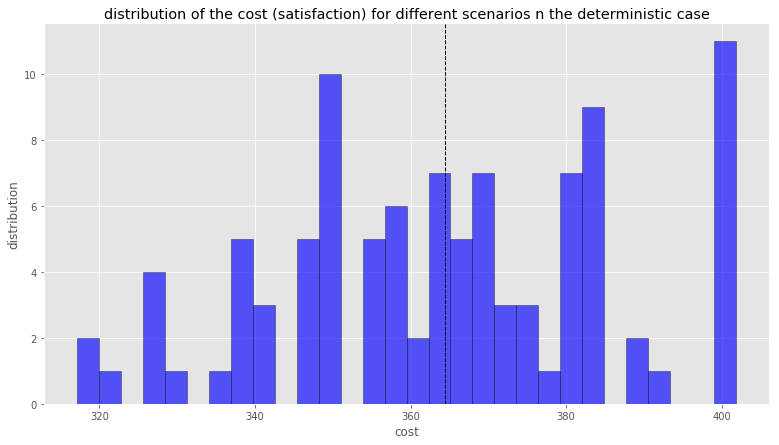

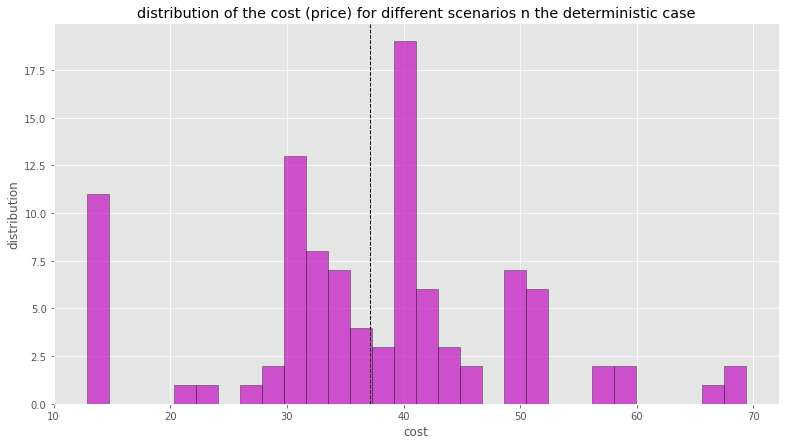

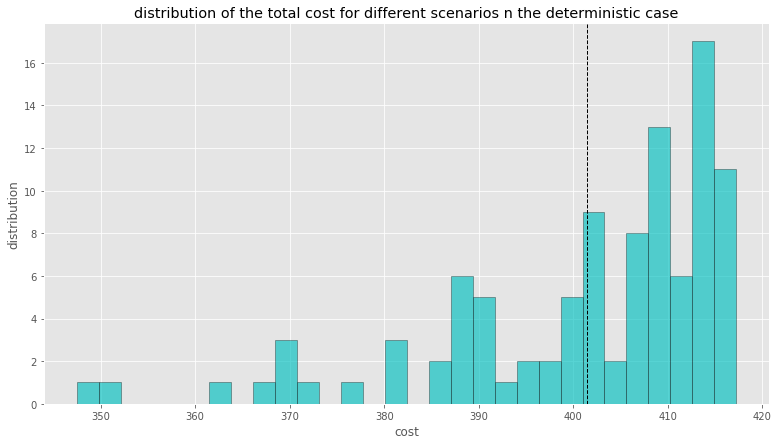

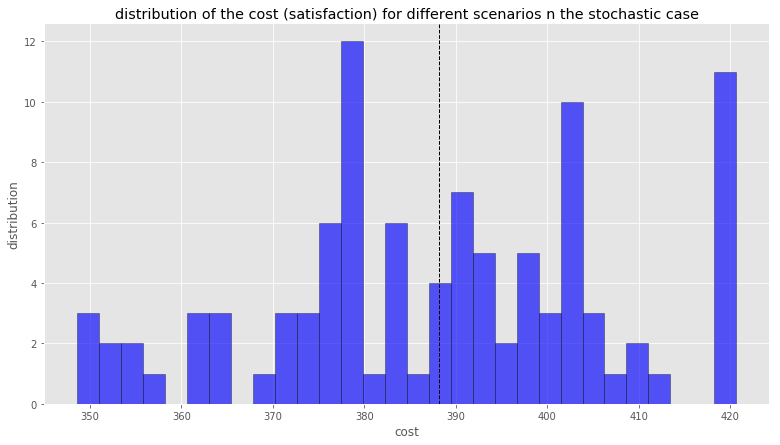

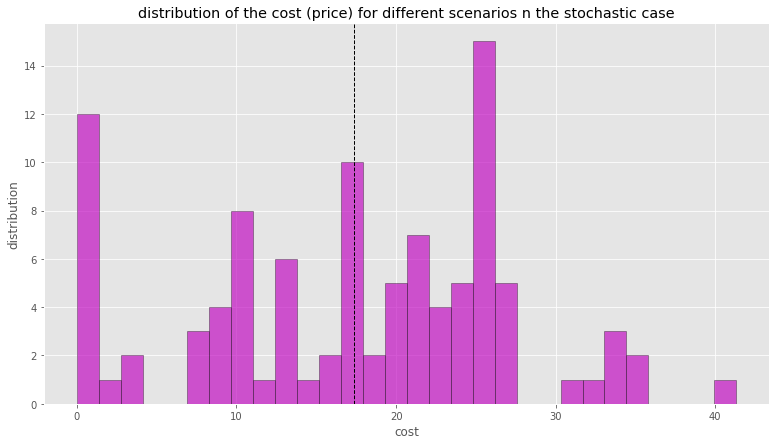

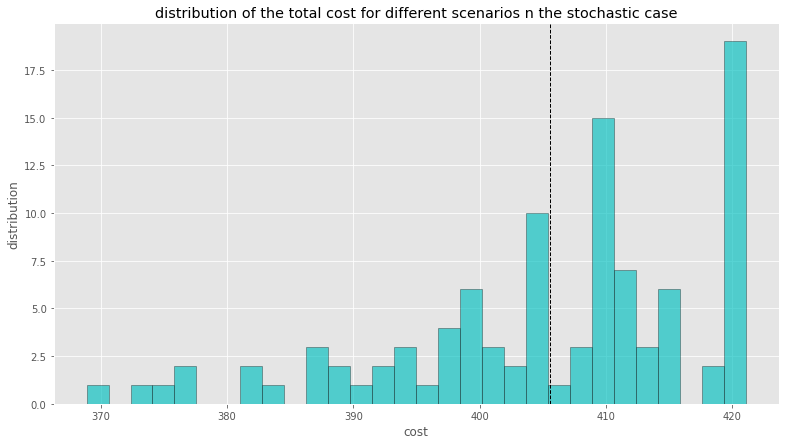

In [420]:
test_cars(deterministic_control, presence_to_test_2, 'deterministic')
test_cars(stochastic_control, presence_to_test_2, 'stochastic')

12.056675910949707 seconds
1.0942420959472656 seconds
stochastic : 
cost :  33.87254526831812
satisaction :  356.5469736933333
total :  390.4195189616517
sum cost :  39432.37141512682
80.7619800567627 seconds
1.17708420753479 seconds
stochastic with prices : 
cost :  29.132289557837172
satisaction :  374.55003865953773
total :  403.6823282173753
sum cost :  40771.915149954904


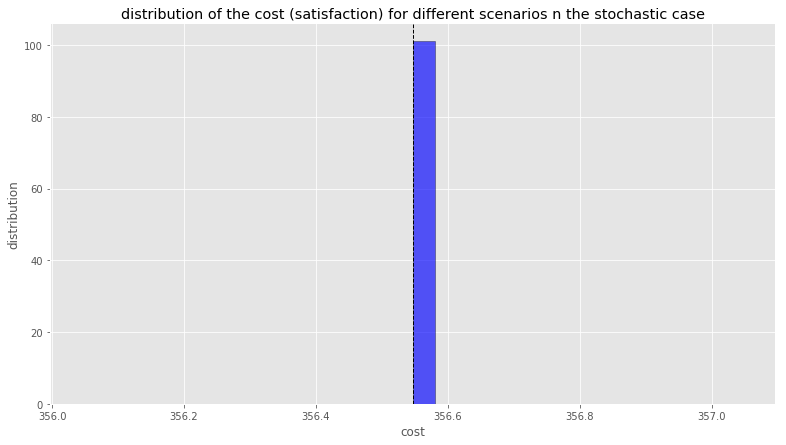

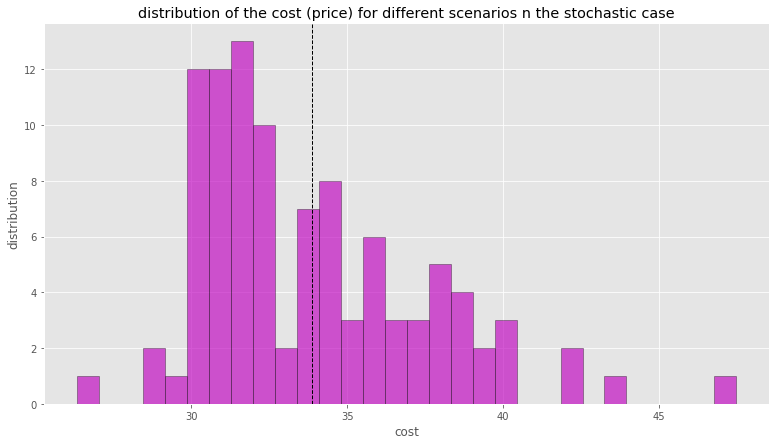

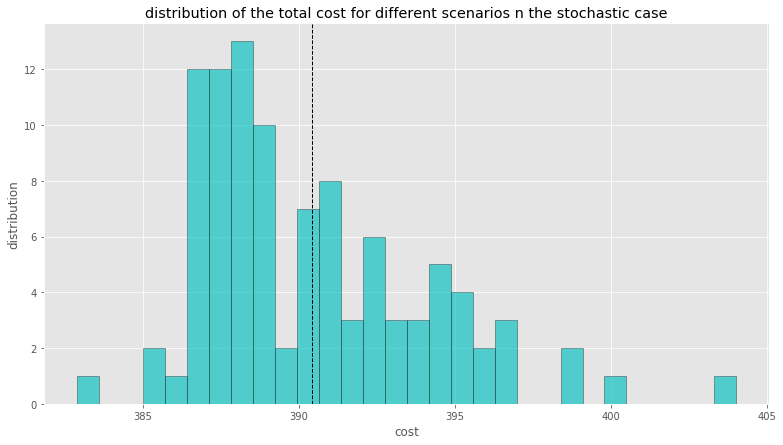

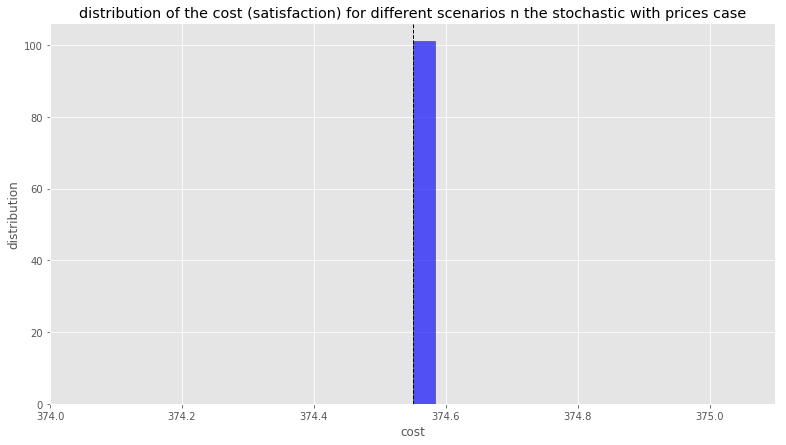

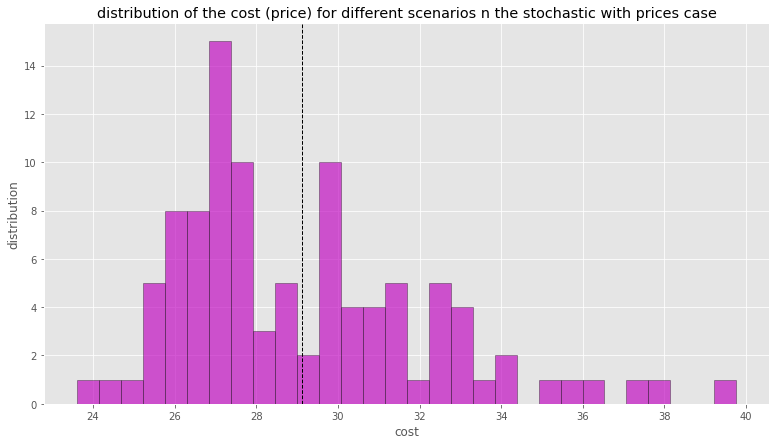

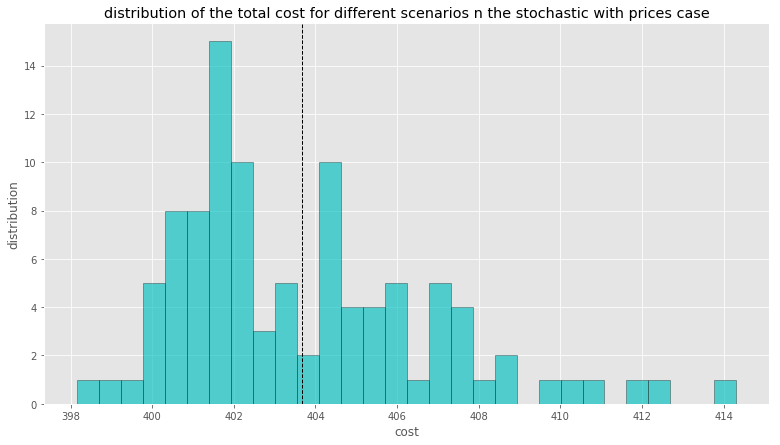

In [418]:
presence = presence_to_test_2[0]
test_prices(stochastic_control, prices_to_test, 'stochastic')
test_prices(stochastic_control_with_price, prices_to_test, 'stochastic with prices')